<a href="https://colab.research.google.com/github/plaban1981/Deep-Learning-KERAS/blob/master/Kitchenware_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

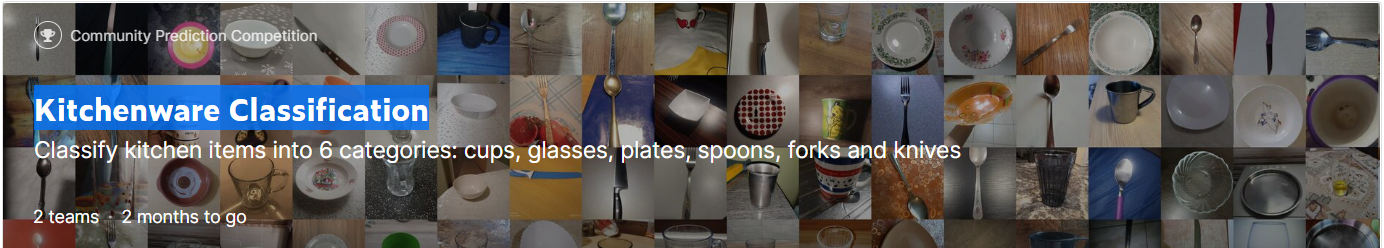

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"e07977afd437047e0247b86b331025b8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c kitchenware-classification

100% 1.38G/1.39G [00:39<00:00, 38.4MB/s]
100% 1.39G/1.39G [00:39<00:00, 37.6MB/s]


In [5]:
! unzip "/content/kitchenware-classification.zip" -d "/content/drive/MyDrive/Kitchen_Classification"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2924.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2925.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2926.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2927.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2928.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2929.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2930.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2931.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2932.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2933.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2934.jpg  
  inflating: /content/drive/MyDrive/Kitchen_Classification/images/2935.jpg  
  inflating: /content/dri

In [6]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
#
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator


In [22]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Kitchen_Classification/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Kitchen_Classification/test.csv")

In [23]:
train.head()

,Id,label
0,2441,glass
1,0,cup
2,2442,glass
3,6535,spoon
4,4814,plate


In [24]:
train['image'] = train['Id'].map(lambda x: f'{x:0>4}.jpg')

In [25]:
train.head()

,Id,label,image
0,2441,glass,2441.jpg
1,0,cup,0000.jpg
2,2442,glass,2442.jpg
3,6535,spoon,6535.jpg
4,4814,plate,4814.jpg


In [26]:
test.head()

,Id
0,6534
1,3504
2,1649
3,4815
4,1651


In [27]:
test['image'] = test['Id'].map(lambda x: f'{x:0>4}.jpg')

In [28]:
test.head()

,Id,image
0,6534,6534.jpg
1,3504,3504.jpg
2,1649,1649.jpg
3,4815,4815.jpg
4,1651,1651.jpg


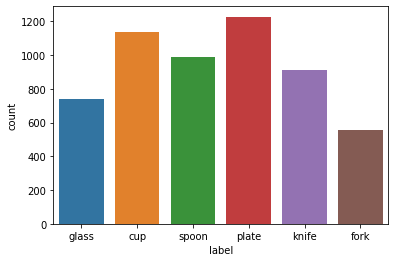

In [105]:
import seaborn as sns
sns.countplot(x='label',data=train)

## Datagenerator

In [31]:
image_size = (224,224)

In [10]:
train_dir = "/content/drive/MyDrive/Kitchen_Classification/images"

In [58]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_dataframe(dataframe=train, directory=train_dir,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=16,
                                             subset='training',
                                             shuffle =True,
                                             seed=7)
 
validation_generator = train_datagen.flow_from_dataframe(dataframe=train, directory=train_dir,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=16,
                                             subset='validation',
                                             shuffle=False,
                                             seed=7)
test_generator = test_datagen.flow_from_dataframe(dataframe=test, directory=train_dir,
                                             x_col='image',
                                             target_size=(224,224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=7)

Found 4448 validated image filenames belonging to 6 classes.
Found 1111 validated image filenames belonging to 6 classes.
Found 2362 validated image filenames.


## Visualize Training Data

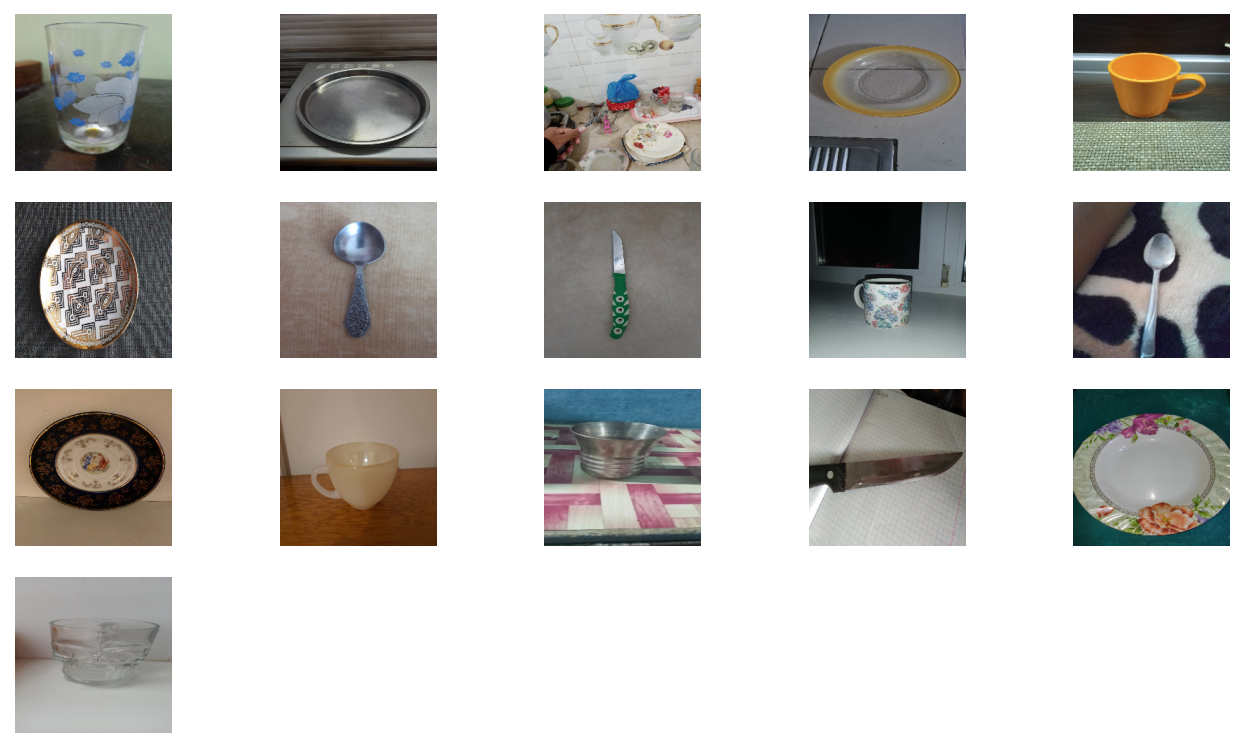

In [93]:
for batch, _ in train_generator:
  plt.figure(figsize=(11, 8),dpi=150)
  for index, image in enumerate(batch, start=1):
    ax = plt.subplot(5, 5, index)
    plt.imshow(image)
    plt.axis('off')
  plt.show()
  break

## Visualize Validation Data

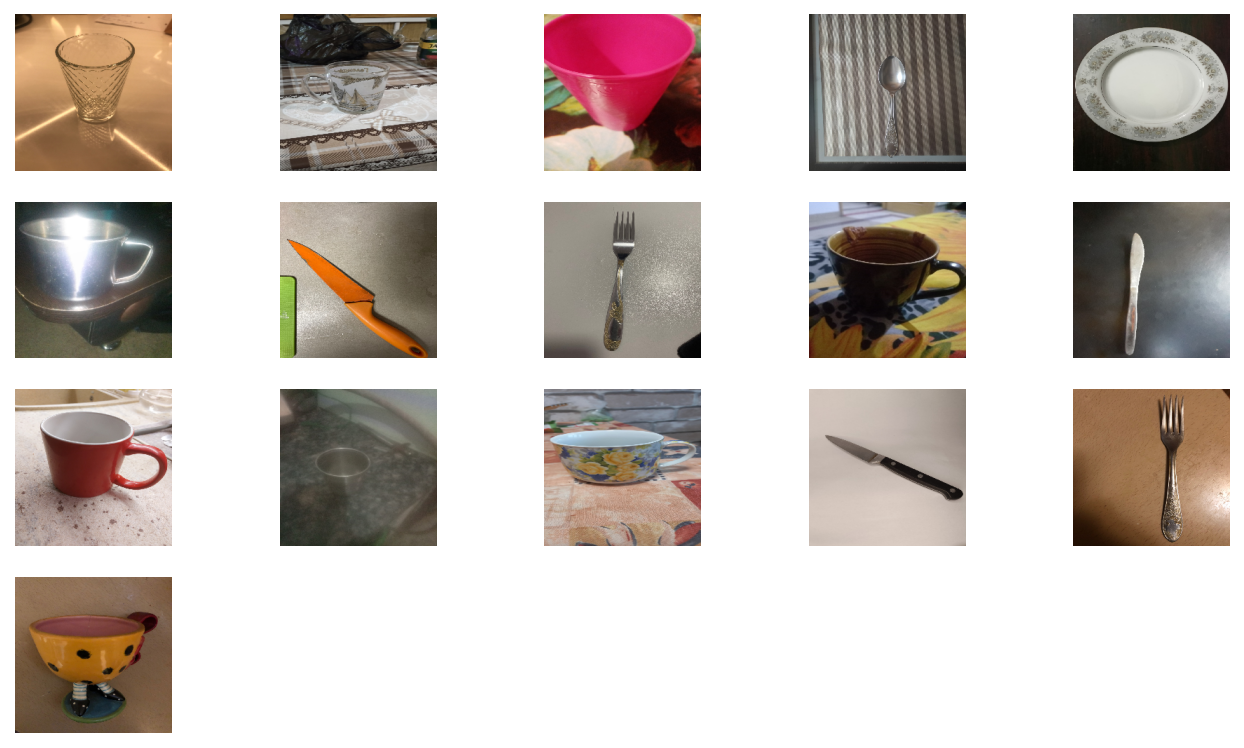

In [95]:
for batch, _ in validation_generator:
  plt.figure(figsize=(11, 8),dpi=150)
  for index, image in enumerate(batch, start=1):
    ax = plt.subplot(5, 5, index)
    plt.imshow(image)
    plt.axis('off')
  plt.show()
  break

## Define the Model

In [53]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetLarge,DenseNet201,ResNet152
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
pretrained_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')

74836368/74836368 [==============================] - 2s 0us/step


## ConvNeXt-TF pretrained Models

In [68]:
import tensorflow_hub as hub
IMAGE_SIZE = [224, 224]
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_base_1k_224_fe/1"
hub_layer = hub.KerasLayer(MODEL_PATH, trainable=True)


In [69]:
num_classes = 6
model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1024)              87566464  
                                                                 
 dense_12 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 87,572,614
Trainable params: 87,572,614
Non-trainable params: 0
_________________________________________________________________


In [54]:
final_model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')])

## Define Callbacks

In [71]:
folderpath = "/content/drive/MyDrive/Kitchen_Classification/Model/"
filepath = folderpath + "epoch:{epoch:02d}-val_loss:{val_loss:.2f}.hdf5"

In [51]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,mode='auto', min_lr=1e-5, verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto'),
      tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)]

## Train the model

In [59]:
epochs = 100
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
final_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = final_model.fit(
    train_generator, 
    epochs=epochs, 
    callbacks=cbs, 
    validation_data=validation_generator
)


Epoch 1/100
278/278 [==============================] - 134s 401ms/step - loss: 1.5731 - accuracy: 0.4867 - val_loss: 6.6755 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 2/100
278/278 [==============================] - 108s 388ms/step - loss: 0.9310 - accuracy: 0.6713 - val_loss: 2.5924 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 3/100
278/278 [==============================] - 126s 452ms/step - loss: 0.7719 - accuracy: 0.7320 - val_loss: 0.6776 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 4/100
278/278 [==============================] - 106s 382ms/step - loss: 0.6641 - accuracy: 0.7756 - val_loss: 0.5246 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 5/100
278/278 [==============================] - 107s 386ms/step - loss: 0.6010 - accuracy: 0.8055 - val_loss: 0.4880 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 6/100
278/278 [==============================] - 103s 371ms/step - loss: 0.5142 - accuracy: 0.8264 - val_loss: 0.5734 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 7/100
278/278 [===================

In [74]:
folderpath = "/content/drive/MyDrive/Kitchen_Classification/Model/"
filepath = folderpath + "convnet_epoch:{epoch:02d}-val_loss:{val_loss:.2f}.hdf5"

In [75]:
filepath

'/content/drive/MyDrive/Kitchen_Classification/Model/convnet_epoch:{epoch:02d}-val_loss:{val_loss:.2f}.hdf5'

In [77]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_generator, 
    epochs=10, 
    callbacks=cbs, 
    validation_data=validation_generator
)


Epoch 1/10
278/278 [==============================] - 299s 1s/step - loss: 0.1446 - accuracy: 0.9559 - val_loss: 0.2576 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 2/10
278/278 [==============================] - 284s 1s/step - loss: 0.1208 - accuracy: 0.9649 - val_loss: 0.2341 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 3/10
278/278 [==============================] - 283s 1s/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 0.2035 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 4/10
278/278 [==============================] - 284s 1s/step - loss: 0.0716 - accuracy: 0.9775 - val_loss: 0.2645 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 5/10
278/278 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9791
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
278/278 [==============================] - 284s 1s/step - loss: 0.0726 - accuracy: 0.9791 - val_loss: 0.3415 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 6/10
278/278 [==============================] - 284s 

## Load the best model

In [61]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Kitchen_Classification/Modelepoch:14-val_loss:0.24.hdf5')

## Make predictions on Validation Data

In [97]:
val_pred = model.predict(validation_generator)

70/70 [==============================] - 24s 320ms/step


In [100]:
val_pred = np.argmax(val_pred,axis=1)

In [103]:
val_pred = val_pred.tolist()

In [102]:
val_true = validation_generator.labels

In [104]:
from sklearn.metrics import classification_report
print(classification_report(val_true,val_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       227
           1       1.00      0.94      0.97       110
           2       0.88      0.93      0.90       146
           3       0.97      0.99      0.98       172
           4       0.97      0.97      0.97       231
           5       0.98      0.99      0.98       225

    accuracy                           0.96      1111
   macro avg       0.96      0.96      0.96      1111
weighted avg       0.96      0.96      0.96      1111



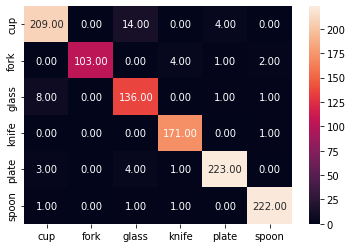

In [106]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_true,val_pred)
sns.heatmap(cm,annot=True,fmt=".2f",xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())

## make Predictions on test data

In [78]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

2362/2362 [==============================] - 163s 68ms/step


In [62]:
train_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [84]:
label_dict = {v:k for k,v in train_generator.class_indices.items()}
label_dict 

{0: 'cup', 1: 'fork', 2: 'glass', 3: 'knife', 4: 'plate', 5: 'spoon'}

In [79]:
pred.shape

(2362, 6)

In [82]:
predictions1 = np.argmax(pred,axis=1)

In [85]:
predictions1.tolist()

[3,
 3,
 1,
 4,
 1,
 1,
 5,
 1,
 3,
 0,
 4,
 2,
 3,
 4,
 5,
 0,
 5,
 0,
 3,
 0,
 1,
 5,
 2,
 4,
 0,
 0,
 3,
 5,
 2,
 3,
 0,
 0,
 0,
 0,
 2,
 4,
 0,
 4,
 4,
 0,
 4,
 2,
 4,
 4,
 3,
 5,
 0,
 0,
 0,
 5,
 0,
 0,
 3,
 0,
 0,
 2,
 3,
 2,
 0,
 2,
 4,
 3,
 3,
 1,
 4,
 5,
 0,
 5,
 0,
 1,
 0,
 3,
 3,
 0,
 2,
 0,
 5,
 5,
 3,
 3,
 5,
 2,
 4,
 0,
 2,
 3,
 4,
 2,
 0,
 3,
 1,
 5,
 3,
 5,
 2,
 2,
 5,
 1,
 5,
 4,
 5,
 4,
 3,
 0,
 4,
 1,
 1,
 0,
 4,
 5,
 5,
 4,
 5,
 4,
 0,
 3,
 2,
 0,
 5,
 2,
 0,
 4,
 4,
 3,
 2,
 4,
 4,
 1,
 4,
 2,
 4,
 0,
 2,
 0,
 1,
 5,
 4,
 0,
 3,
 1,
 0,
 4,
 3,
 1,
 2,
 5,
 3,
 2,
 0,
 5,
 3,
 2,
 0,
 1,
 3,
 1,
 3,
 4,
 5,
 0,
 5,
 3,
 4,
 3,
 3,
 2,
 3,
 2,
 3,
 4,
 1,
 2,
 3,
 4,
 5,
 3,
 5,
 0,
 1,
 4,
 5,
 2,
 5,
 0,
 2,
 3,
 5,
 0,
 1,
 5,
 3,
 0,
 4,
 5,
 2,
 5,
 0,
 2,
 4,
 3,
 5,
 0,
 4,
 0,
 5,
 2,
 3,
 3,
 5,
 4,
 4,
 2,
 4,
 3,
 4,
 1,
 5,
 3,
 2,
 4,
 0,
 4,
 5,
 0,
 1,
 4,
 5,
 0,
 3,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 4,
 4,
 1,
 3,
 4,
 3,
 3,
 2,
 1,
 0,
 0,
 4,
 4,
 0,


In [86]:
final_pred = [label_dict[i] for i in predictions1.tolist()]

In [87]:
final_pred

['knife',
 'knife',
 'fork',
 'plate',
 'fork',
 'fork',
 'spoon',
 'fork',
 'knife',
 'cup',
 'plate',
 'glass',
 'knife',
 'plate',
 'spoon',
 'cup',
 'spoon',
 'cup',
 'knife',
 'cup',
 'fork',
 'spoon',
 'glass',
 'plate',
 'cup',
 'cup',
 'knife',
 'spoon',
 'glass',
 'knife',
 'cup',
 'cup',
 'cup',
 'cup',
 'glass',
 'plate',
 'cup',
 'plate',
 'plate',
 'cup',
 'plate',
 'glass',
 'plate',
 'plate',
 'knife',
 'spoon',
 'cup',
 'cup',
 'cup',
 'spoon',
 'cup',
 'cup',
 'knife',
 'cup',
 'cup',
 'glass',
 'knife',
 'glass',
 'cup',
 'glass',
 'plate',
 'knife',
 'knife',
 'fork',
 'plate',
 'spoon',
 'cup',
 'spoon',
 'cup',
 'fork',
 'cup',
 'knife',
 'knife',
 'cup',
 'glass',
 'cup',
 'spoon',
 'spoon',
 'knife',
 'knife',
 'spoon',
 'glass',
 'plate',
 'cup',
 'glass',
 'knife',
 'plate',
 'glass',
 'cup',
 'knife',
 'fork',
 'spoon',
 'knife',
 'spoon',
 'glass',
 'glass',
 'spoon',
 'fork',
 'spoon',
 'plate',
 'spoon',
 'plate',
 'knife',
 'cup',
 'plate',
 'fork',
 'fork

In [88]:
test.head()

,Id,image
0,6534,6534.jpg
1,3504,3504.jpg
2,1649,1649.jpg
3,4815,4815.jpg
4,1651,1651.jpg


In [89]:
test['label'] = final_pred

In [90]:
test.head()

,Id,image,label
0,6534,6534.jpg,knife
1,3504,3504.jpg,knife
2,1649,1649.jpg,fork
3,4815,4815.jpg,plate
4,1651,1651.jpg,fork


In [91]:
test[['Id','label']].to_csv('ConvNet.csv',index=False)

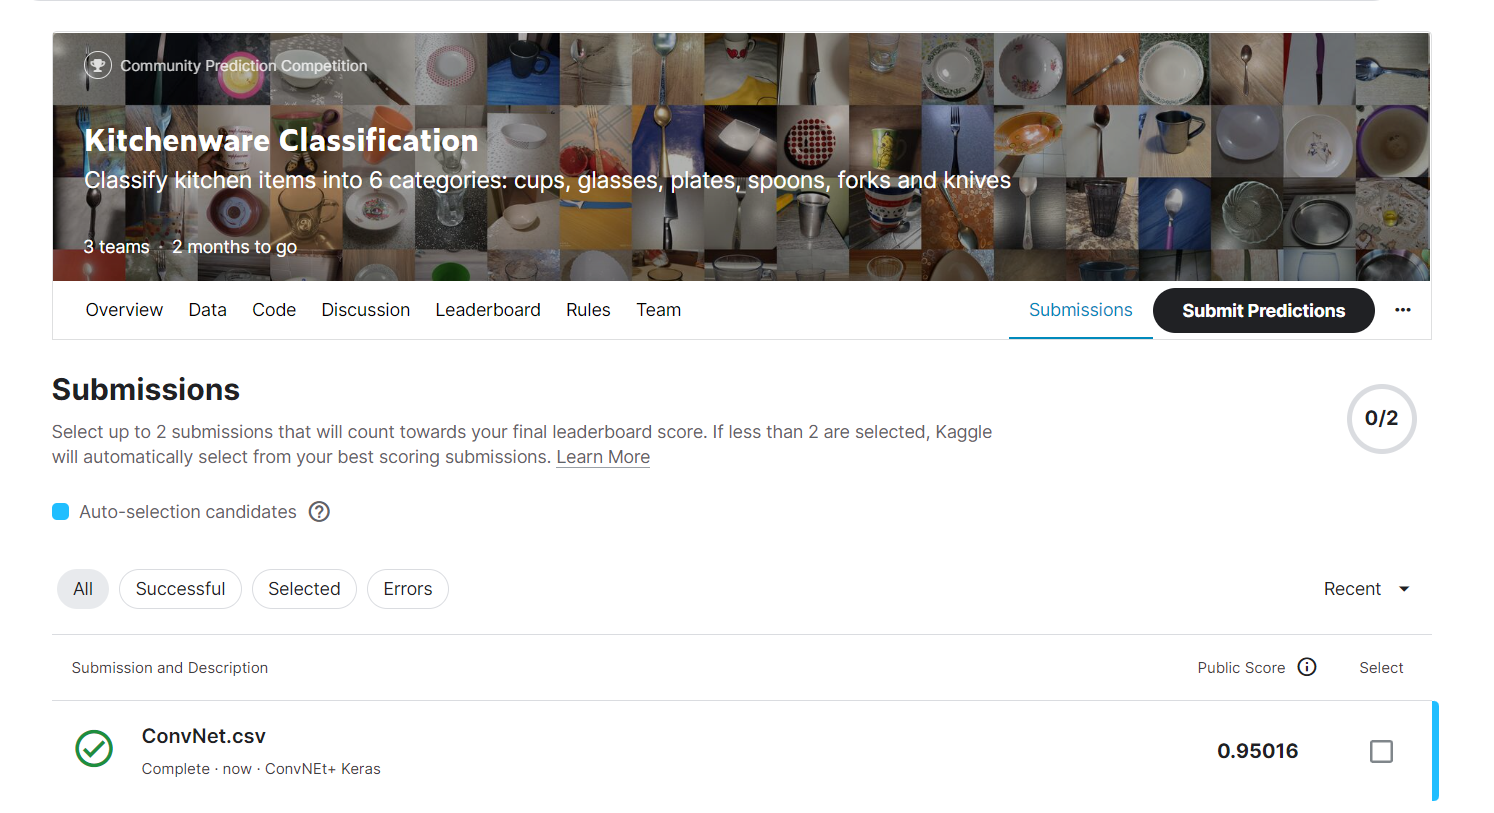

In [92]:
import shutil
shutil.move("/content/ConvNet.csv","/content/drive/MyDrive/Kitchen_Classification")

'/content/drive/MyDrive/Kitchen_Classification/ConvNet.csv'